In [3]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
import faiss

def processing_documents(document, chunk_size: int, chunk_overlap: int, embedding_model: str, dimension: int) -> FAISS:
   loader = PyPDFLoader(file_path=document)
   docs = loader.load()
   text_splitter = RecursiveCharacterTextSplitter(
      chunk_size=chunk_size, chunk_overlap=chunk_overlap
   )
   chunks = text_splitter.split_documents(docs)
   embeddings = HuggingFaceEmbeddings(model_name=embedding_model)
   vector_store = FAISS(
      embedding_function=embeddings,
      index=faiss.IndexFlatL2(dimension),
      docstore=InMemoryDocstore(),
      index_to_docstore_id={}
   )
   vector_store.add_documents(chunks)
   return vector_store

In [4]:
from langchain_community.vectorstores import FAISS
from langchain_core.tools import BaseTool
from typing import Type
from pydantic import BaseModel, Field

class RetrieverInput(BaseModel):
   query: str = Field(description="Query User untuk mencari informasi pada dokumen")

class Retrieve(BaseTool):
   name: str = "document_retrieve_tool"
   description: str = "Gunakan tools ini untuk mencari informasi berkaitan dengan Akuntansi, Finansial, dan Perbankan"
   response_format: str = "content_and_artifact"
   args_schema: Type[BaseModel] = RetrieverInput
   vector_store: FAISS
   search_type: str
   k: int

   def _run(self, query: str) -> dict[str, any]:
      retrieve_docs = self.vector_store.similarity_search(query=query, k=self.k)
      serialized = "\n\n".join(
         (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}") 
         for doc in retrieve_docs
      )
      return serialized, retrieve_docs

In [5]:
from dataclasses import dataclass

@dataclass
class QNAModel:
   model: str = "gemini-1.5-pro"
   temperature: float = 0.8
   top_p: float = 0.6
   max_tokens: int = 2000

@dataclass
class Embedding:
   model: str = "intfloat/multilingual-e5-small"
   dimension: int = 384

@dataclass
class ChunkStrategy:
   chunk_size: int = 500
   chunk_overlap: int = 10

@dataclass
class VectorSearchStrateg:
   method: str = "similarity"
   k: int = 3

@dataclass
class Configuration:
   qna_model: QNAModel = QNAModel()
   embedding: Embedding = Embedding()
   chunk_strategy: ChunkStrategy = ChunkStrategy()
   vector_search_strategy: VectorSearchStrateg = VectorSearchStrateg()


In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage
from langgraph.graph import MessagesState, StateGraph, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from dotenv import load_dotenv
import os

load_dotenv()
config = Configuration().qna_model
gemini_api = os.environ["GOOGLE_GENERATIVE_AI"]
llm_model = ChatGoogleGenerativeAI(
   model=config.model,
   temperature=config.temperature,
   top_p=config.top_p,
   max_tokens=config.max_tokens,
   api_key=gemini_api
)

def retrieve_or_response(state: MessagesState, vector_store, search_type, k):
   """Tentukan langkah untuk menggunakan tools atau langsung merespon"""
   llm_with_tools = llm_model.bind_tools([Retrieve(vector_store=vector_store, search_type=search_type, k=k)])
   response = llm_with_tools.invoke(state['messages'])
   return {"messages": [response]}

def generate(state: MessagesState):
   """Generate a response."""
   print(state["messages"])
   recent_tool_messages = []
   for message in reversed(state["messages"]):
      if message.type == "tool":
         recent_tool_messages.append(message)
      else:
         break
   tool_messages = recent_tool_messages[::-1]

   system_message_content = system_prompt(tool_messages)

   conversation_messages = [
      message
      for message in state["messages"]
      if message.type in ("human", "system")
      or (message.type == "ai" and not message.tool_calls)
   ]
   prompt = [SystemMessage(system_message_content)] + conversation_messages
   print(prompt)
   response = llm_model.invoke(prompt)
   return {"messages": [response]}


def graph_architecture(vector_store, search_type, k) -> StateGraph:
   graph_builder = StateGraph(MessagesState)
   tools = ToolNode([Retrieve(vector_store=vector_store, search_type=search_type, k=k)])
   memory = MemorySaver()

   graph_builder.add_node("retrieve_or_response", lambda MessagesState: retrieve_or_response(MessagesState, vector_store, search_type, k))
   graph_builder.add_node(tools)
   graph_builder.add_node("generate", generate)

   graph_builder.set_entry_point("retrieve_or_response")
   graph_builder.add_conditional_edges(
      "retrieve_or_response",
      tools_condition,
      {
         END: END,
         "tools": "tools"
      }
   )

   graph_builder.add_edge(start_key="tools", end_key="generate")
   graph_builder.add_edge(start_key="generate", end_key=END)
   graph = graph_builder.compile(checkpointer=memory)

   graph_builder.add_edge(start_key="tools", end_key="generate")
   graph_builder.add_edge(start_key="generate", end_key=END)
   graph = graph_builder.compile(checkpointer=memory)
   return graph

In [7]:
import uuid

config = Configuration()
vector_store = processing_documents(
   document="../temp/document.pdf",
   chunk_size=config.chunk_strategy.chunk_size,
   chunk_overlap=config.chunk_strategy.chunk_overlap,
   embedding_model=config.embedding.model,
   dimension=config.embedding.dimension
)
graph = graph_architecture(
   vector_store=vector_store,
   search_type=config.vector_search_strategy.method,
   k=config.vector_search_strategy.k
)

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


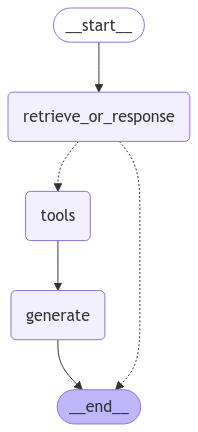

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
vector_store.search(query="SAK ETAP adalah", search_type="similarity", k=3)

[Document(metadata={'source': '../temp/document.pdf', 'page': 60}, page_content='kreditur. SAK ETAP membantu perusahaan kecil menengah dalam \nmenyediakan pelaporan keuangan yang tetap relevan dan andal. SAK ETAP \nakan khusus digunakan unutk perusahaan tanpa akuntabilitas publik yang \nsignifikan. Perusahaan yang terdaftar dalam bursa efek dan yang memiliki \nakuntabilitas publik signifikan tetap harus menggunakan PSAK yang umum. \n \n1.2 Pengakuan Unsur Laporan Keuangan \n       Menurut SAK ETAP nomor 2 paragraf 24, pengakuan unsur laporan keuangan'),
 Document(metadata={'source': '../temp/document.pdf', 'page': 61}, page_content='kreditur. SAK ETAP membantu perusahaan kecil menengah dalam \nmenyediakan pelaporan keuangan yang tetap relevan dan andal. SAK ETAP \nakan khusus digunakan unutk perusahaan tanpa akuntabilitas publik yang \nsignifikan. Perusahaan yang terdaftar dalam bursa efek dan yang memiliki \nakuntabilitas publik signifikan tetap harus menggunakan PSAK yang umum. \n \n

In [10]:
from langchain_core.messages import HumanMessage

question= "apa itu SAK ETAP"

config = {
   "configurable": {
      "thread_id": str(uuid.uuid4())
   }
}

inputs = {
   "messages": [{
      "role": "human",
      "content": question,
   }]
}

for msg, metadata in graph.stream(inputs, config, stream_mode="messages"):
    if (
        msg.content
        and not isinstance(msg, HumanMessage)
        and metadata["langgraph_node"] == "generate"
    ):
        print(msg.content, end="|", flush=True)

[HumanMessage(content='apa itu SAK ETAP', additional_kwargs={}, response_metadata={}, id='77bb0267-e1ab-47e2-9e6c-9e435dcf952d'), AIMessage(content='SAK ETAP adalah Standar Akuntansi Keuangan Entitas Tanpa Akuntabilitas Publik.  SAK ETAP merupakan standar akuntansi yang dirancang khusus untuk entitas tanpa akuntabilitas publik.  Entitas tanpa akuntabilitas publik  adalah entitas yang tidak memiliki akuntabilitas publik signifikan dan menerbitkan laporan keuangan umum untuk tujuan umum bagi pengguna eksternal.  Contoh pengguna eksternal adalah  kreditur, investor, dan lembaga pemeringkat kredit.\n', additional_kwargs={'function_call': {'name': 'document_retrieve_tool', 'arguments': '{"query": "SAK ETAP"}'}}, response_metadata={'safety_ratings': [], 'finish_reason': 'STOP'}, id='run-c3b988c6-4647-44db-b7cd-1d59fd28976f', tool_calls=[{'name': 'document_retrieve_tool', 'args': {'query': 'SAK ETAP'}, 'id': '61b619dc-e4e2-4e6d-a585-afe8c014fd4b', 'type': 'tool_call'}], usage_metadata={'input

In [34]:
inputs = {
   "messages": [{
      "role": "human",
      "content": "halo",
   }]
}

msg_list = []
metadata_list = []

for msg, metadata in graph.stream(inputs, config, stream_mode="messages"):
    msg_list.append(msg)
    metadata_list.append(metadata)
    print(msg.content, end="|", flush=True)
    print(metadata)

Halo|{'thread_id': '412fc076-3cab-4319-afcb-a52cd0c96732', 'langgraph_step': 59, 'langgraph_node': 'retrieve_or_response', 'langgraph_triggers': ['start:retrieve_or_response'], 'langgraph_path': ('__pregel_pull', 'retrieve_or_response'), 'langgraph_checkpoint_ns': 'retrieve_or_response:89aee3fa-dd17-1d99-ac22-84db5b8651c3', 'checkpoint_ns': 'retrieve_or_response:89aee3fa-dd17-1d99-ac22-84db5b8651c3', 'ls_provider': 'google_genai', 'ls_model_name': 'models/gemini-1.5-pro', 'ls_model_type': 'chat', 'ls_temperature': 0.8, 'ls_max_tokens': 2000}
! Ada yang bisa saya bantu?
|{'thread_id': '412fc076-3cab-4319-afcb-a52cd0c96732', 'langgraph_step': 59, 'langgraph_node': 'retrieve_or_response', 'langgraph_triggers': ['start:retrieve_or_response'], 'langgraph_path': ('__pregel_pull', 'retrieve_or_response'), 'langgraph_checkpoint_ns': 'retrieve_or_response:89aee3fa-dd17-1d99-ac22-84db5b8651c3', 'checkpoint_ns': 'retrieve_or_response:89aee3fa-dd17-1d99-ac22-84db5b8651c3', 'ls_provider': 'google_g

In [35]:
msg_list

[AIMessageChunk(content='Halo', additional_kwargs={}, response_metadata={'safety_ratings': []}, id='run-5016fe68-610d-4799-ad97-7dddf7ca33eb', usage_metadata={'input_tokens': 6352, 'output_tokens': 0, 'total_tokens': 6352, 'input_token_details': {'cache_read': 0}}),
 AIMessageChunk(content='! Ada yang bisa saya bantu?\n', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'safety_ratings': []}, id='run-5016fe68-610d-4799-ad97-7dddf7ca33eb', usage_metadata={'input_tokens': 0, 'output_tokens': 9, 'total_tokens': 9, 'input_token_details': {'cache_read': 0}})]

In [36]:
metadata_list

[{'thread_id': '412fc076-3cab-4319-afcb-a52cd0c96732',
  'langgraph_step': 59,
  'langgraph_node': 'retrieve_or_response',
  'langgraph_triggers': ['start:retrieve_or_response'],
  'langgraph_path': ('__pregel_pull', 'retrieve_or_response'),
  'langgraph_checkpoint_ns': 'retrieve_or_response:89aee3fa-dd17-1d99-ac22-84db5b8651c3',
  'checkpoint_ns': 'retrieve_or_response:89aee3fa-dd17-1d99-ac22-84db5b8651c3',
  'ls_provider': 'google_genai',
  'ls_model_name': 'models/gemini-1.5-pro',
  'ls_model_type': 'chat',
  'ls_temperature': 0.8,
  'ls_max_tokens': 2000},
 {'thread_id': '412fc076-3cab-4319-afcb-a52cd0c96732',
  'langgraph_step': 59,
  'langgraph_node': 'retrieve_or_response',
  'langgraph_triggers': ['start:retrieve_or_response'],
  'langgraph_path': ('__pregel_pull', 'retrieve_or_response'),
  'langgraph_checkpoint_ns': 'retrieve_or_response:89aee3fa-dd17-1d99-ac22-84db5b8651c3',
  'checkpoint_ns': 'retrieve_or_response:89aee3fa-dd17-1d99-ac22-84db5b8651c3',
  'ls_provider': 'goo

In [19]:
steps_list

[(AIMessageChunk(content='', additional_kwargs={'function_call': {'name': 'document_retrieve_tool', 'arguments': '{"query": "SAK ETAP"}'}}, response_metadata={'safety_ratings': []}, id='run-d0ad41bc-c53a-4348-b568-5b1ae653ac10', tool_calls=[{'name': 'document_retrieve_tool', 'args': {'query': 'SAK ETAP'}, 'id': 'dc140516-1ca0-4612-a0ab-4b80ddac99c2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 3090, 'output_tokens': 0, 'total_tokens': 3090, 'input_token_details': {'cache_read': 0}}, tool_call_chunks=[{'name': 'document_retrieve_tool', 'args': '{"query": "SAK ETAP"}', 'id': 'dc140516-1ca0-4612-a0ab-4b80ddac99c2', 'index': None, 'type': 'tool_call_chunk'}]),
  {'thread_id': '412fc076-3cab-4319-afcb-a52cd0c96732',
   'langgraph_step': 26,
   'langgraph_node': 'retrieve_or_response',
   'langgraph_triggers': ['start:retrieve_or_response'],
   'langgraph_path': ('__pregel_pull', 'retrieve_or_response'),
   'langgraph_checkpoint_ns': 'retrieve_or_response:5e7437cb-8c21-5f56-6021-5

In [13]:
for step in graph.stream(input=inputs, config=config, stream_mode="messages"):
   if "__end__" in step:
      step["messages"][-1].pretty_print()

[HumanMessage(content='apa itu SAK ETAP', additional_kwargs={}, response_metadata={}, id='77bb0267-e1ab-47e2-9e6c-9e435dcf952d'), AIMessage(content='SAK ETAP adalah Standar Akuntansi Keuangan Entitas Tanpa Akuntabilitas Publik.  SAK ETAP merupakan standar akuntansi yang dirancang khusus untuk entitas tanpa akuntabilitas publik.  Entitas tanpa akuntabilitas publik  adalah entitas yang tidak memiliki akuntabilitas publik signifikan dan menerbitkan laporan keuangan umum untuk tujuan umum bagi pengguna eksternal.  Contoh pengguna eksternal adalah  kreditur, investor, dan lembaga pemeringkat kredit.\n', additional_kwargs={'function_call': {'name': 'document_retrieve_tool', 'arguments': '{"query": "SAK ETAP"}'}}, response_metadata={'safety_ratings': [], 'finish_reason': 'STOP'}, id='run-c3b988c6-4647-44db-b7cd-1d59fd28976f', tool_calls=[{'name': 'document_retrieve_tool', 'args': {'query': 'SAK ETAP'}, 'id': '61b619dc-e4e2-4e6d-a585-afe8c014fd4b', 'type': 'tool_call'}], usage_metadata={'input

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
